Calculating AUC just for single task ID.<br> Therefore, not making a scalable solution for POC.

In [166]:
import json
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import tensorflow as tf
import pprint as pp
import math
import random
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [167]:
filepath = "../data/student_vectors_n_task_10_n_limit_10000.json"
student_vectors = json.load(open(filepath))

In [168]:
task_ids = []
for i in student_vectors:
    for j in student_vectors[i]:
        if j['task_id'] not in task_ids:
            task_ids.append(j['task_id'])
print("Number of unique task IDs: " + str(len(task_ids)))
print("Number of students: " + str(len(student_vectors)))

Number of unique task IDs: 10
Number of students: 1255


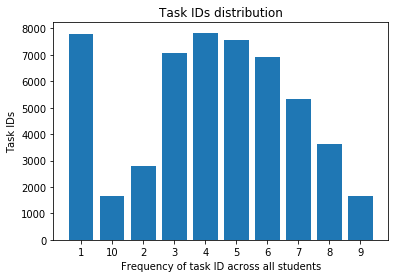

Task IDs mapping: 
Task ID -> p7cfRPp-kQ.partb(1) is attempted 7776 times.
Task ID -> Ok-iIHxjgx.partb(2) is attempted 2789 times.
Task ID -> 1zsCldT4p8.set1(3) is attempted 7061 times.
Task ID -> DebcfZEEmI.proper_fractions(4) is attempted 7836 times.
Task ID -> 9wRCzK1G7F.partb(5) is attempted 7552 times.
Task ID -> 1zsCldT4p8.set2(6) is attempted 6905 times.
Task ID -> nl-M69Ez9k.parta(7) is attempted 5335 times.
Task ID -> kvig7fcCVc.partb(8) is attempted 3621 times.
Task ID -> Ok-iIHxjgx.parta(9) is attempted 1670 times.
Task ID -> hyei4uD81i.parta(10) is attempted 1664 times.


In [177]:
#frequency distribution of taskids
cnt2 = Counter()
another_2 = {}
position_2 = 1
for i in student_vectors:
    for j in student_vectors[i]:
        if j['task_id'] not in another_2:
            another_2[j['task_id']] = str(position_2)
            position_2 = position_2 + 1
        cnt2[another_2[j['task_id']]] += 1
plt.bar(cnt2.keys(), cnt2.values())
plt.title("Task IDs distribution")
plt.xlabel("Frequency of task ID across all students")
plt.ylabel("Task IDs")
plt.show()
print("Task IDs mapping: ")
for i in another_2:
    print("Task ID -> "+str(i)+"("+str(another_2[i])+") is attempted " + str(cnt2[another_2[i]]) + " times.")

In [223]:
test_AUC_all_tasks = {}
train_AUC_all_tasks = {}
for i in another_2:
    print("\n\n\nCalculating for Task ID: "+str(i)+" which has the frequency: " + str(cnt2[another_2[i]]) + "\n")
    train_AUC_taski = []
    test_AUC_taski = []
    #make sequences
    sequences = []
    sequences_lengths = []
    sequences_op = []
    for p in student_vectors:
        interactions = []
        results = []
        for j in student_vectors[p]:
            if(j['task_id'] == i and j['second_try'] == False):
                if(j['correct'] == True):
                    interactions.append([1.,0.])
                    results.append([1.])
                else:
                    interactions.append([0.,1.])
                    results.append([-1.])
        if(len(interactions) > 1):
            sequences_lengths.append(len(interactions))
            sequences.append(interactions)
            sequences_op.append(results)

    #do the padding
    padded_sequences = np.zeros([len(sequences),max(sequences_lengths),2])
    for p in range(len(sequences)):
        for j in range(len(sequences[p])):
            padded_sequences[p][j] = sequences[p][j]
    padded_sequences_op = np.zeros([len(sequences),max(sequences_lengths),1])
    for p in range(len(sequences_op)):
        for j in range(len(sequences_op[p])):
            padded_sequences_op[p][j] = sequences_op[p][j]

    #split the train and test set like BKT
    split = int(0.8*len(sequences))
    train_x = padded_sequences[:split,:-1]
    train_y = padded_sequences_op[:split,1:]
    train_seqlen = sequences_lengths[:split]
    test_x = padded_sequences[split:,:-1]
    test_y = padded_sequences_op[split:,1:]
    test_seqlen = sequences_lengths[split:]

    num_units = 5
    len_vector = 2
    l_rate = 0.1
    epochs = 100
    display_ep = 10
    
    for r in range(10):
        print("\n\n"+ str(r+1) + " Time Run.")
        # build the network
        tf.reset_default_graph()
        #placeholders
        x = tf.placeholder(tf.float32, [None, max(sequences_lengths)-1, len_vector])
        y = tf.placeholder(tf.float32, [None, max(sequences_lengths)-1, len_vector-1])
        seqlen_tf = tf.placeholder(tf.float32,[None])

        #dynamic RNN definition
        def dynamicRNN(x):
            rnn_cell = tf.nn.rnn_cell.BasicLSTMCell(num_units)
            outputs, states = tf.nn.dynamic_rnn(rnn_cell, x, dtype=tf.float32,sequence_length=seqlen_tf)
            out_size = len_vector-1
            outputs = tf.contrib.layers.fully_connected(outputs, out_size, activation_fn = tf.nn.sigmoid)
            outputs = tf.nn.sigmoid(outputs)
            return outputs

        pred = dynamicRNN(x)
        cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=pred, labels=y))
        #optimizer = tf.train.AdamOptimizer(learning_rate=l_rate).minimize(cost)
        optimizer = tf.train.MomentumOptimizer(learning_rate=l_rate,momentum=0.9).minimize(cost)
        auc,  opts = tf.metrics.auc(labels = y, predictions = pred, curve='ROC')

        #execute the network
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            sess.run(tf.local_variables_initializer())
            for epoch in range(1, epochs+1):
                sess.run(optimizer, feed_dict={x: train_x, y: train_y, seqlen_tf: train_seqlen})
                if epoch % display_ep == 0 or epoch == 1:
                    loss, trainAUC, trainOPTS = sess.run([cost,auc,opts], feed_dict={x: train_x, y: train_y, seqlen_tf: train_seqlen})
                    testAUC, testOPTS = sess.run([auc,opts], feed_dict={x: test_x, y: test_y, seqlen_tf: test_seqlen})
                    print("Step: " + str(epoch) +", cost: "+str(loss)+ ", train set AUC: " + str(trainOPTS) +":"+str(trainAUC) + ", test set AUC: "+ str(testOPTS)+":"+str(testAUC) +";")
            prediction = sess.run([pred], feed_dict={x: test_x, y: test_y, seqlen_tf: test_seqlen})
            view_point = np.argmax(test_seqlen)
            print("\n\ntrue:\n")
            print(test_x[view_point][:test_seqlen[view_point]])
            print("\n\nprediction\n")
            print(prediction[0][view_point][:test_seqlen[view_point]])
            train_AUC_taski.append(trainOPTS)
            test_AUC_taski.append(testOPTS)
    test_AUC_all_tasks[i] = [np.mean(test_AUC_taski),np.std(test_AUC_taski)]
    train_AUC_all_tasks[i] = [np.mean(train_AUC_taski),np.std(train_AUC_taski)]




Calculating for Task ID: p7cfRPp-kQ.partb which has the frequency: 7776



1 Time Run.
Step: 1, cost: 0.99630404, train set AUC: 0.8783179:0.0, test set AUC: 0.87344044:0.8783179;
Step: 10, cost: 0.9919577, train set AUC: 0.67716646:0.87344044, test set AUC: 0.661765:0.67716646;
Step: 20, cost: 0.9833942, train set AUC: 0.58238006:0.661765, test set AUC: 0.5743213:0.58238006;
Step: 30, cost: 0.9741366, train set AUC: 0.5615452:0.5743213, test set AUC: 0.56538486:0.5615452;
Step: 40, cost: 0.9657436, train set AUC: 0.5544938:0.56538486, test set AUC: 0.5568185:0.5544938;
Step: 50, cost: 0.9589004, train set AUC: 0.54182833:0.5568185, test set AUC: 0.5406557:0.54182833;
Step: 60, cost: 0.9537014, train set AUC: 0.53118014:0.5406557, test set AUC: 0.5307628:0.53118014;
Step: 70, cost: 0.94967747, train set AUC: 0.52230877:0.5307628, test set AUC: 0.5214982:0.52230877;
Step: 80, cost: 0.9466473, train set AUC: 0.51995844:0.5214982, test set AUC: 0.52149355:0.51995844;
Step: 90, cost: 0.

Step: 1, cost: 0.996359, train set AUC: 0.28774688:0.0, test set AUC: 0.29575974:0.28774688;
Step: 10, cost: 0.992016, train set AUC: 0.27538994:0.29575974, test set AUC: 0.26676625:0.27538994;
Step: 20, cost: 0.98345655, train set AUC: 0.3394055:0.26676625, test set AUC: 0.34354293:0.3394055;
Step: 30, cost: 0.9741978, train set AUC: 0.39530024:0.34354293, test set AUC: 0.40441883:0.39530024;
Step: 40, cost: 0.9658021, train set AUC: 0.42898428:0.40441883, test set AUC: 0.43438706:0.42898428;
Step: 50, cost: 0.9589486, train set AUC: 0.44292077:0.43438706, test set AUC: 0.44438136:0.44292077;
Step: 60, cost: 0.95374286, train set AUC: 0.45156047:0.44438136, test set AUC: 0.45345354:0.45156047;
Step: 70, cost: 0.94971734, train set AUC: 0.45336133:0.45345354, test set AUC: 0.45322567:0.45336133;
Step: 80, cost: 0.9466831, train set AUC: 0.4596777:0.45322567, test set AUC: 0.46196777:0.4596777;
Step: 90, cost: 0.9444214, train set AUC: 0.4596506:0.46196777, test set AUC: 0.45932:0.45965

Step: 1, cost: 1.0019395, train set AUC: 0.49985605:0.0, test set AUC: 0.50087255:0.49985605;
Step: 10, cost: 0.9973051, train set AUC: 0.4355538:0.50087255, test set AUC: 0.42554563:0.4355538;
Step: 20, cost: 0.9883001, train set AUC: 0.43558413:0.42554563, test set AUC: 0.43204248:0.43558413;
Step: 30, cost: 0.97858506, train set AUC: 0.44377175:0.43204248, test set AUC: 0.4428926:0.44377175;
Step: 40, cost: 0.9698849, train set AUC: 0.4498205:0.4428926, test set AUC: 0.44874084:0.4498205;
Step: 50, cost: 0.96290845, train set AUC: 0.4483177:0.44874084, test set AUC: 0.4460649:0.4483177;
Step: 60, cost: 0.9575721, train set AUC: 0.4459796:0.4460649, test set AUC: 0.44438544:0.4459796;
Step: 70, cost: 0.9536051, train set AUC: 0.44746497:0.44438544, test set AUC: 0.44729194:0.44746497;
Step: 80, cost: 0.95061433, train set AUC: 0.4491656:0.44729194, test set AUC: 0.44884896:0.4491656;
Step: 90, cost: 0.9483469, train set AUC: 0.44325835:0.44884896, test set AUC: 0.44136995:0.44325835;

Step: 20, cost: 0.9883404, train set AUC: 0.5287059:0.58101165, test set AUC: 0.5193069:0.5287059;
Step: 30, cost: 0.9787133, train set AUC: 0.51194805:0.5193069, test set AUC: 0.510955:0.51194805;
Step: 40, cost: 0.97009975, train set AUC: 0.50685066:0.510955, test set AUC: 0.5062653:0.50685066;
Step: 50, cost: 0.9631362, train set AUC: 0.4981056:0.5062653, test set AUC: 0.49471325:0.4981056;
Step: 60, cost: 0.9578016, train set AUC: 0.49181142:0.49471325, test set AUC: 0.4902721:0.49181142;
Step: 70, cost: 0.9538073, train set AUC: 0.49193573:0.4902721, test set AUC: 0.49238864:0.49193573;
Step: 80, cost: 0.9507968, train set AUC: 0.49333155:0.49238864, test set AUC: 0.49363014:0.49333155;
Step: 90, cost: 0.94850546, train set AUC: 0.4943952:0.49363014, test set AUC: 0.49464917:0.4943952;
Step: 100, cost: 0.9467189, train set AUC: 0.491559:0.49464917, test set AUC: 0.49052715:0.491559;


true:

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]


Step: 30, cost: 0.9713318, train set AUC: 0.66290164:0.7237796, test set AUC: 0.65732735:0.66290164;
Step: 40, cost: 0.9630106, train set AUC: 0.62655944:0.65732735, test set AUC: 0.6238278:0.62655944;
Step: 50, cost: 0.956316, train set AUC: 0.60437846:0.6238278, test set AUC: 0.6021068:0.60437846;
Step: 60, cost: 0.95107037, train set AUC: 0.5874421:0.6021068, test set AUC: 0.5854682:0.5874421;
Step: 70, cost: 0.9471134, train set AUC: 0.5742142:0.5854682, test set AUC: 0.5718998:0.5742142;
Step: 80, cost: 0.94404984, train set AUC: 0.5650232:0.5718998, test set AUC: 0.5641746:0.5650232;
Step: 90, cost: 0.94176024, train set AUC: 0.56019676:0.5641746, test set AUC: 0.55908084:0.56019676;
Step: 100, cost: 0.93993294, train set AUC: 0.55544794:0.55908084, test set AUC: 0.55450225:0.55544794;


true:

[[0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]

Step: 50, cost: 0.95622337, train set AUC: 0.52626526:0.53300357, test set AUC: 0.5244391:0.52626526;
Step: 60, cost: 0.95102274, train set AUC: 0.5200406:0.5244391, test set AUC: 0.5186738:0.5200406;
Step: 70, cost: 0.9470548, train set AUC: 0.51262075:0.5186738, test set AUC: 0.5102447:0.51262075;
Step: 80, cost: 0.9440017, train set AUC: 0.5107291:0.5102447, test set AUC: 0.5108229:0.5107291;
Step: 90, cost: 0.9417173, train set AUC: 0.50913715:0.5108229, test set AUC: 0.5078702:0.50913715;
Step: 100, cost: 0.9398971, train set AUC: 0.5056721:0.5078702, test set AUC: 0.50455725:0.5056721;


true:

[[0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]


prediction

[[0.5222594 ]
 [0.5238645 ]
 [0.520

Step: 70, cost: 0.94708055, train set AUC: 0.52853096:0.5346936, test set AUC: 0.52655804:0.52853096;
Step: 80, cost: 0.9440235, train set AUC: 0.5264225:0.52655804, test set AUC: 0.5269322:0.5264225;
Step: 90, cost: 0.9417305, train set AUC: 0.52716213:0.5269322, test set AUC: 0.526633:0.52716213;
Step: 100, cost: 0.93991387, train set AUC: 0.52327025:0.526633, test set AUC: 0.52201086:0.52327025;


true:

[[0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]


prediction

[[0.52530545]
 [0.5256795 ]
 [0.52590287]
 [0.52588874]
 [0.5260851 ]
 [0.52584946]
 [0.52609503]
 [0.5259707 ]
 [0.52595556]
 [0.5255618 ]
 [0.52623504]
 [0.526104  ]
 [0.5260642 ]
 [0.5255008 ]
 [0.52634686]
 [0.52564675]
 [0.5258

KeyboardInterrupt: 

In [209]:
pp.pprint(test_AUC_all_tasks)
pp.pprint(train_AUC_all_tasks)

{'1zsCldT4p8.set1': [0.53794026, 0.00097266294],
 '1zsCldT4p8.set2': [0.5463648, 0.0017357237],
 '9wRCzK1G7F.partb': [0.5366205, 0.0012712833],
 'DebcfZEEmI.proper_fractions': [0.5482954, 0.0042706993],
 'Ok-iIHxjgx.parta': [0.57228684, 0.01144236],
 'Ok-iIHxjgx.partb': [0.5255308, 0.005434483],
 'hyei4uD81i.parta': [0.4890855, 0.013791313],
 'kvig7fcCVc.partb': [0.5793609, 0.015127081],
 'nl-M69Ez9k.parta': [0.5464407, 0.0048880684],
 'p7cfRPp-kQ.partb': [0.546174, 0.0008474268]}
{'1zsCldT4p8.set1': [0.5368773, 0.00082156423],
 '1zsCldT4p8.set2': [0.5437304, 0.0016803223],
 '9wRCzK1G7F.partb': [0.530423, 0.0014787491],
 'DebcfZEEmI.proper_fractions': [0.545999, 0.0049521686],
 'Ok-iIHxjgx.parta': [0.566645, 0.0108796265],
 'Ok-iIHxjgx.partb': [0.5231419, 0.004775264],
 'hyei4uD81i.parta': [0.4891215, 0.012124698],
 'kvig7fcCVc.partb': [0.57128054, 0.014244122],
 'nl-M69Ez9k.parta': [0.5430025, 0.0058070677],
 'p7cfRPp-kQ.partb': [0.54173, 0.0007197173]}
